# Poetry generation challenge

This notebook serves as a challenge on how to create poetry like Shakespeare by leveraging RNNs(LSTMs). We'll be using the Shakerpeare poetry as the training data and then use the trained network to predict the next words.

In [1]:
##import the required libraries and APIs
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(tf.__version__)

2.8.0


## Step 1: Create a corpus

In [2]:
##printing the text
shakespeare_text = open('./sonnets.txt').read()
print(len(shakespeare_text))

28893


In [3]:
##create corpus by lowering the letters and splitting the text by \n
corpus = shakespeare_text.lower().split("\n")

## Set up the tokenizer

In [4]:
##set up tokenizer
tokenizer = Tokenizer()

In [5]:
tokenizer.fit_on_texts(corpus)

##calculate vocabulary size - be mindful of the <oov> token
vocab_size = len(tokenizer.word_index) + 1

print(tokenizer.word_index)
print(vocab_size)

{'and': 1, 'the': 2, 'to': 3, 'thou': 4, 'in': 5, 'my': 6, 'of': 7, 'i': 8, 'thy': 9, 'that': 10, 'with': 11, 'thee': 12, 'for': 13, 'but': 14, 'not': 15, 'a': 16, 'love': 17, 'be': 18, 'all': 19, 'me': 20, 'when': 21, 'so': 22, 'by': 23, 'then': 24, 'is': 25, 'which': 26, 'as': 27, 'this': 28, 'from': 29, 'his': 30, 'self': 31, 'do': 32, 'thine': 33, 'it': 34, 'on': 35, 'art': 36, 'if': 37, 'eyes': 38, 'more': 39, 'or': 40, 'beauty': 41, 'mine': 42, 'doth': 43, 'you': 44, 'your': 45, 'time': 46, 'sweet': 47, 'make': 48, 'one': 49, 'where': 50, 'their': 51, 'fair': 52, 'her': 53, 'are': 54, 'yet': 55, 'day': 56, 'what': 57, 'see': 58, 'who': 59, 'than': 60, 'can': 61, 'should': 62, 'own': 63, 'shall': 64, 'how': 65, 'no': 66, 'hath': 67, 'will': 68, 'were': 69, 'live': 70, 'those': 71, 'him': 72, 'let': 73, 'may': 74, 'o': 75, 'night': 76, "love's": 77, 'now': 78, 'world': 79, 'she': 80, 'nor': 81, 'they': 82, "beauty's": 83, 'dost': 84, 'he': 85, 'give': 86, 'eye': 87, 'still': 88, 's

In [6]:
##create sequences of 
input_sequences = []
for line in corpus:
    tokens = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(tokens)):
        n_gram_sequence = tokens[:i+1]
        input_sequences.append(n_gram_sequence)


In [7]:
##pad sequences
max_seq_len = max([len(i) for i in input_sequences])
input_seq_array = np.array(pad_sequences(input_sequences,
                                         maxlen=max_seq_len,
                                         padding='pre')
                        )

In [8]:
##creating features(X) and label(y)
X = input_seq_array[:, :-1]
labels = input_seq_array[:, -1]

##one-hot encode the labels to get y - since it is actually just a classification problem
y = tf.keras.utils.to_categorical(labels, num_classes=vocab_size)

## Define the LSTM model

In [9]:
model = tf.keras.Sequential([
                tf.keras.layers.Embedding(vocab_size, 120, input_length=max_seq_len-1),
                tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(120)),
                tf.keras.layers.Dense(vocab_size, activation='softmax')
])

##define the learning rate - step size for optimizer
adam = tf.keras.optimizers.Adam(lr=0.01)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 120)           185280    
                                                                 
 bidirectional (Bidirectiona  (None, 240)              231360    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1544)              372104    
                                                                 
Total params: 788,744
Trainable params: 788,744
Non-trainable params: 0
_________________________________________________________________


C:\Users\TUBA\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [10]:
from keras.callbacks import EarlyStopping
es=EarlyStopping(monitor='accuracy', mode='max', min_delta=0.001, patience=8)
history = model.fit(X, y, epochs=200, verbose=1 , callbacks=[es])

Epoch 1/200
142/142 [==============================] - 5s 16ms/step - loss: 6.7207 - accuracy: 0.0212
Epoch 2/200
142/142 [==============================] - 2s 16ms/step - loss: 6.1005 - accuracy: 0.0351
Epoch 3/200
142/142 [==============================] - 2s 15ms/step - loss: 5.4925 - accuracy: 0.0630
Epoch 4/200
142/142 [==============================] - 2s 13ms/step - loss: 4.5191 - accuracy: 0.1357
Epoch 5/200
142/142 [==============================] - 2s 15ms/step - loss: 3.3482 - accuracy: 0.2793
Epoch 6/200
142/142 [==============================] - 2s 15ms/step - loss: 2.2602 - accuracy: 0.4806
Epoch 7/200
142/142 [==============================] - 3s 18ms/step - loss: 1.4935 - accuracy: 0.6540
Epoch 8/200
142/142 [==============================] - 2s 16ms/step - loss: 0.9860 - accuracy: 0.7733
Epoch 9/200
142/142 [==============================] - 2s 14ms/step - loss: 0.7097 - accuracy: 0.8405
Epoch 10/200
142/142 [==============================] - 2s 15ms/step - loss: 0.575

## Visualise the metrics

In [11]:
import matplotlib.pyplot as plt


def plot_metric(history, metric):
  plt.plot(history.history[metric])
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.show()

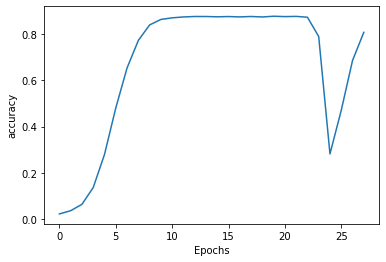

In [12]:
plot_metric(history, 'accuracy')

## Generate new text

In [13]:
seed_text = "It was a cold night."
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding='pre')
	predicted= np.argmax(model.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

It was a cold night. beauteous day well gems it love's tomb it was me alone skill thee me in me more nearly you still weep gone as a tomb speak hath the world it not love's fine gems days muse die thee me me alone forth cross gone her it gazeth me me but this mine mine mine eyes be supposed heart heart one of the world away faces ' one one one one but not what it is it not love's fine wit so so chary me alone tomb they see thee are one age and land ' ' honour me me me
